# Model selection

In this notebook we will do the model selection and predictions.

# TOC

* [1 Loading the data](#1-Loading-the-data)
* [2 Mean prediction](#2-Mean-prediction)
* [3 Make loss function](#3-Make-loss-function)
* [4 Validation generation](#4-Validation-generation)
* [5 Hyperparameter optimization](#5-Hyperparameter-optimization)
    * [5.1 Linear Regression](#5.1-Linear-Regression)
    * [5.2 Lasso](#5.2-Lasso)
    * [5.3 Ridge](#5.3-Ridge)
    * [5.4 KNN](#5.4-KNN)
    * [5.5 Extremely Randomized Trees](#5.5-Extremely-Randomized-Trees)
    * [5.6 Gradient Boosting Decision Tree](#5.6-Gradient-Boosting-Decision-Tree)
    * [5.7 Neural Network](#5.7-Neural-Network)
* [6 Ensembling](#6-Ensembling)

# 1 Loading the data

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
import gc
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from pathlib import Path
from sklearn import model_selection
from sklearn import metrics

In [3]:
# Set the random seeds
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

# Possible more fixes for non-determinism
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926
# https://github.com/keras-team/keras/issues/2280#issuecomment-366542480
import os
from keras import backend as k

os.environ['PYTHONHASHSEED'] = '0'
sess = tf.Session(graph=tf.get_default_graph())

# Limit operation to 1 thread for deterministic results.
# NOTE: This will slow down the operation
# session_conf = tf.ConfigProto(
#     intra_op_parallelism_threads=1,
#     inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)

k.set_session(sess)

Using TensorFlow backend.


In [4]:
generated_data = Path('.').absolute().joinpath('generated_data')

target_name = 'item_cnt_month'
dt_data = pd.read_hdf(generated_data.joinpath('dt_data.hdf'), key='dt_data')
non_dt_data = pd.read_hdf(generated_data.joinpath('non_dt_data.hdf'), key='non_dt_data')

Ensure that the order of features are consistent.

**NOTE**: We do this step as it appears that two columns have been swapped somewhere in the process, leadning to a `xgb` error of feature mismatch.

In [5]:
order = ['date_block_num',
         'shop_revenue_avg', 
         'shop_unique_items_len',
         'shop_id_mean_mean_enc', 
         'item_id_mean_mean_enc', 
         'item_category_id_mean_mean_enc',
         'month_shop_item_id_item_cnt_sum_lag_1',
         'month_shop_item_id_item_cnt_sum_lag_2',
         'month_shop_item_id_item_cnt_sum_lag_3', 
         'month_shop_item_id_item_cnt_sum_lag_6',
         'month_shop_item_id_item_cnt_sum_lag_9',
         'month_shop_item_id_item_cnt_sum_lag_12',
         'month_shop_item_cnt_sum_lag_1', 
         'month_shop_item_cnt_sum_lag_2',
         'month_shop_item_cnt_sum_lag_3',
         'month_shop_item_cnt_sum_lag_6', 
         'month_shop_item_cnt_sum_lag_9', 
         'month_shop_item_cnt_sum_lag_12', 
         'month_item_id_item_cnt_sum_lag_1', 
         'month_item_id_item_cnt_sum_lag_2', 
         'month_item_id_item_cnt_sum_lag_3', 
         'month_item_id_item_cnt_sum_lag_6',
         'month_item_id_item_cnt_sum_lag_9', 
         'month_item_id_item_cnt_sum_lag_12', 
         'month_shop_item_id_item_cnt_max_lag_1',
         'month_shop_item_id_item_cnt_min_lag_1', 
         'month_shop_item_id_item_cnt_avg_lag_1',
         'month_shop_item_cat_item_cnt_avg_lag_1', 
         'month_shop_item_cnt_avg_lag_1', 
         'month_shop_revenue_sum_lag_1', 
         'month_item_id_item_cnt_max_lag_1', 
         'month_item_id_item_cnt_min_lag_1',
         'month_item_id_item_cnt_avg_lag_1',
         'month_item_cat_item_cnt_avg_lag_1',
         'month_item_cnt_avg_lag_1', 
         'year', 
         'month', 
         'days_in_month', 
         'quarter', 
         'prev_holiday_count',
         'holiday_count', 
         'next_holiday_count', 
         'item_name_cyrillic_words', 
         'item_name_latin_words', 
         'item_name_total_words', 
         'item_category_name_cyrillic_words', 
         'item_category_name_latin_words', 
         'item_category_name_total_words', 
         'shop_name_cyrillic_words', 
         'shop_name_latin_words', 
         'shop_name_total_words', 
         'nlp_nmf_0', 
         'nlp_nmf_1',
         'nlp_nmf_2', 
         'nlp_nmf_3', 
         'nlp_nmf_4',
         'nlp_nmf_5', 
         'nlp_nmf_6', 
         'nlp_nmf_7', 
         'nlp_nmf_8', 
         'nlp_nmf_9',
         'nlp_nmf_10',
         'nlp_nmf_11',
         'nlp_nmf_12', 
         'nlp_nmf_13', 
         'shop_id_count', 
         'item_id_count',
         'ID',
         target_name]

dt_data = dt_data.loc[:, order]
non_dt_data = non_dt_data.loc[:, order]

In [6]:
train_dt = dt_data.loc[dt_data.loc[:, 'date_block_num'] < dt_data.loc[:, 'date_block_num'].max()].copy()
target = train_dt.loc[:, [target_name]]
train_dt.drop(target_name, axis=1, inplace=True)
test_dt = dt_data.loc[dt_data.loc[:, 'date_block_num'] == dt_data.loc[:, 'date_block_num'].max()].copy()
test_dt.drop(target_name, axis=1, inplace=True)

In [7]:
train_dt.head()

,date_block_num,shop_revenue_avg,shop_unique_items_len,shop_id_mean_mean_enc,item_id_mean_mean_enc,item_category_id_mean_mean_enc,month_shop_item_id_item_cnt_sum_lag_1,month_shop_item_id_item_cnt_sum_lag_2,month_shop_item_id_item_cnt_sum_lag_3,month_shop_item_id_item_cnt_sum_lag_6,...,nlp_nmf_7,nlp_nmf_8,nlp_nmf_9,nlp_nmf_10,nlp_nmf_11,nlp_nmf_12,nlp_nmf_13,shop_id_count,item_id_count,ID
4836056,13,1694.803589,4849,1.864983,3.170994,1.810461,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.052124,0.0,0.0,31091,1425,22987
4836057,13,1694.803589,4849,1.864983,2.455285,1.502383,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.052002,0.0,0.0,31091,1152,20994
4836058,13,1694.803589,4849,1.864983,2.546222,1.810461,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.052124,0.0,0.0,31091,1926,20995
4836059,13,1694.803589,4849,1.864983,1.487214,1.502383,1.0,1.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.052002,0.0,0.0,31091,872,22492
4836060,13,1694.803589,4849,1.864983,1.144688,1.810461,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.051923,0.0,0.0,31091,122,-1


In [8]:
target.head()

,item_cnt_month
4836056,0.0
4836057,0.0
4836058,0.0
4836059,0.0
4836060,0.0


In [9]:
test_dt.head()

,date_block_num,shop_revenue_avg,shop_unique_items_len,shop_id_mean_mean_enc,item_id_mean_mean_enc,item_category_id_mean_mean_enc,month_shop_item_id_item_cnt_sum_lag_1,month_shop_item_id_item_cnt_sum_lag_2,month_shop_item_id_item_cnt_sum_lag_3,month_shop_item_id_item_cnt_sum_lag_6,...,nlp_nmf_7,nlp_nmf_8,nlp_nmf_9,nlp_nmf_10,nlp_nmf_11,nlp_nmf_12,nlp_nmf_13,shop_id_count,item_id_count,ID
10913804,34,999.513611,7084,1.687958,3.054798,2.447195,0.0,1.0,3.0,1.0,...,0.0,0.045069,0.000008,0.0,0.0,0.000000,0.0,43279,1131,0
10913805,34,999.513611,7084,1.687958,2.022818,1.401470,0.0,0.0,0.0,0.0,...,0.0,0.000175,0.000000,0.0,0.0,0.000717,0.0,43279,42,1
10913806,34,999.513611,7084,1.687958,2.022818,2.447195,1.0,3.0,1.0,3.0,...,0.0,0.057511,0.000000,0.0,0.0,0.002660,0.0,43279,492,2
10913807,34,999.513611,7084,1.687958,2.022818,2.276257,0.0,0.0,1.0,0.0,...,0.0,0.054715,0.000000,0.0,0.0,0.001130,0.0,43279,172,3
10913808,34,999.513611,7084,1.687958,2.022818,4.099669,0.0,0.0,0.0,0.0,...,0.0,0.041322,0.000000,0.0,0.0,0.008223,0.0,43279,42,4


In [10]:
# NOTE: We have normalized 'date_block_num' in non_dt_data, so we should be careful to use this as a filter
#       as this is now a float value
#       Instead we use the index values
train_non_dt = non_dt_data.iloc[:train_dt.shape[0]].copy()
train_non_dt.drop(target_name, axis=1, inplace=True)
test_non_dt = non_dt_data.iloc[train_dt.shape[0]:].copy()
test_non_dt.drop(target_name, axis=1, inplace=True)

In [11]:
train_non_dt.head()

,date_block_num,shop_revenue_avg,shop_unique_items_len,shop_id_mean_mean_enc,item_id_mean_mean_enc,item_category_id_mean_mean_enc,month_shop_item_id_item_cnt_sum_lag_1,month_shop_item_id_item_cnt_sum_lag_2,month_shop_item_id_item_cnt_sum_lag_3,month_shop_item_id_item_cnt_sum_lag_6,...,nlp_nmf_7,nlp_nmf_8,nlp_nmf_9,nlp_nmf_10,nlp_nmf_11,nlp_nmf_12,nlp_nmf_13,shop_id_count,item_id_count,ID
4836056,0.0,1.151248,-1.092652,-0.175373,1.011900,-0.113768,-0.238821,-0.238954,-0.236965,-0.228271,...,-0.291978,-0.401959,-0.305314,-0.344527,3.005140,-0.399755,-0.220102,-0.725087,1.564022,0.107320
4836057,0.0,1.151248,-1.092652,-0.175373,0.509209,-0.415623,-0.238821,-0.238954,-0.236965,-0.228271,...,-0.291978,-0.401959,-0.305314,-0.344527,2.997307,-0.399755,-0.220102,-0.725087,1.174312,0.098016
4836058,0.0,1.151248,-1.092652,-0.175373,0.573081,-0.113768,0.607733,-0.238954,-0.236965,-0.228271,...,-0.291978,-0.401959,-0.305314,-0.344527,3.005140,-0.399755,-0.220102,-0.725087,2.279202,0.098021
4836059,0.0,1.151248,-1.092652,-0.175373,-0.170732,-0.415623,0.607733,0.581867,1.388090,-0.228271,...,-0.291978,-0.401959,-0.305314,-0.344527,2.997307,-0.399755,-0.220102,-0.725087,0.774610,0.105009
4836060,0.0,1.151248,-1.092652,-0.175373,-0.411311,-0.113768,-0.238821,-0.238954,-0.236965,-0.228271,...,-0.291978,-0.401959,-0.305314,-0.344527,2.992241,-0.399755,-0.220102,-0.725087,-0.296020,0.000000


In [12]:
test_non_dt.head()

,date_block_num,shop_revenue_avg,shop_unique_items_len,shop_id_mean_mean_enc,item_id_mean_mean_enc,item_category_id_mean_mean_enc,month_shop_item_id_item_cnt_sum_lag_1,month_shop_item_id_item_cnt_sum_lag_2,month_shop_item_id_item_cnt_sum_lag_3,month_shop_item_id_item_cnt_sum_lag_6,...,nlp_nmf_7,nlp_nmf_8,nlp_nmf_9,nlp_nmf_10,nlp_nmf_11,nlp_nmf_12,nlp_nmf_13,shop_id_count,item_id_count,ID
10913804,1.0,-0.519424,-0.35227,-0.584783,0.930288,0.510103,-0.238821,0.581867,2.200617,0.572138,...,-0.291978,2.811774,-0.304835,-0.344527,-0.337275,-0.399755,-0.220102,-0.4464,1.144335,0.000005
10913805,1.0,-0.519424,-0.35227,-0.584783,0.205459,-0.514498,-0.238821,-0.238954,-0.236965,-0.228271,...,-0.291978,-0.389502,-0.305314,-0.344527,-0.337275,-0.356030,-0.220102,-0.4464,-0.410220,0.000009
10913806,1.0,-0.519424,-0.35227,-0.584783,0.205459,0.510103,0.607733,2.223509,0.575562,2.172956,...,-0.291978,3.699026,-0.305314,-0.344527,-0.337275,-0.237552,-0.220102,-0.4464,0.232158,0.000014
10913807,1.0,-0.519424,-0.35227,-0.584783,0.205459,0.342618,-0.238821,-0.238954,0.575562,-0.228271,...,-0.291978,3.499636,-0.305314,-0.344527,-0.337275,-0.330862,-0.220102,-0.4464,-0.224644,0.000019
10913808,1.0,-0.519424,-0.35227,-0.584783,0.205459,2.129198,-0.238821,-0.238954,-0.236965,-0.228271,...,-0.291978,2.544614,-0.305314,-0.344527,-0.337275,0.101762,-0.220102,-0.4464,-0.410220,0.000023


In [13]:
del dt_data
del non_dt_data
gc.collect()

39

# 2 Mean prediction

Before we start we should do some rudimental model predictions.

The file `sample_submission.csv.gz` contains the constant prediction `0.5`, and gives the score `1.23646` against the kaggle site.

Furthermore we know that the optimal prediction for a constant is a target mean (of the ground truth).
Nevertheless, we can probe the leaderboard with target mean of the training set.

In [14]:
mean_prediction = test_dt.loc[:, ['ID']]
mean_prediction.loc[:, 'item_cnt_month'] = target.loc[:, 'item_cnt_month'].mean()

# Set ID as index
mean_prediction.set_index('ID', inplace=True)

mean_prediction.to_csv(generated_data.joinpath('mean_prediction.csv'))
mean_prediction.head()

,item_cnt_month
ID,
0,0.286379
1,0.286379
2,0.286379
3,0.286379
4,0.286379


The mean prediction gave a score of `1.21744`, which is worse than our initial submission.
This means that on average, predictions with lower values are preferred over predicitions with higher values.

We can in fact use this to probe the leaderboard. As we know that the constant target mean of the ground thruth gives the lowest score, we can check whether `0.2` is a minimum (at least of the public test set).

In [15]:
prediction_02 = mean_prediction.copy()
prediction_02.loc[:, 'item_cnt_month'] = 0.2
prediction_02.to_csv(generated_data.joinpath('prediction_02.csv'))
prediction_02.head()

,item_cnt_month
ID,
0,0.2
1,0.2
2,0.2
3,0.2
4,0.2


This degraded the score to `1.22032`.

We could continue to probe the leader board like this to find the minimum to get a direction on what our prediction mean should be close to. However, we must bear in mind that we are only probing the public part of the test set, so we must use this technique with care.

# 3 Make loss function

It appears that the RSME is not available as a loss function out of the box, so we define it ourselves.
This also give us the oppurtunity to clip the predictions to $[0,20]$

In [16]:
def rmse_clip(ground_truth, predictions):
    """
    Returns the root mean squared error of the predictions
    
    The root mean squared error is defined by:
    $\sqrt {\frac {\sum _{t=1}^{T}({\hat {y}}_{t}-y_{t})^{2}}{T}}$
    
    Note
    ----
    This version clips the predictions to [0, 20]
    
    Parameters
    ----------
    ground_truth : array, shape (n_samples,)
        The correct prediction
    prediction : array, shape (n_samples,)
        The predictions
        
    Returns
    -------
    rmse : float
        The root mean squared error
    """
    return np.sqrt(metrics.mean_squared_error(ground_truth, predictions.clip(0, 20)))

# 4 Validation generation

As we want to predict for the next month, we know that train-test is split by time (we would like to predict for month $34$).

In addition, from [0_EDA_raw_data.ipynb](0_EDA_raw_data.ipynb), we saw that different band of item ids were removed (i.e. non-random row numbers were removed in the training set). 

As a rule of thumb we should mimic the validation in the similar manner. The time component is fairly straigth forward. The question is whether it makes sense to take out bands of item id in addition. This is of course testable, and due to time constraints we will just split by time here.

**NOTE**: We could have used `sklearn.model_selectionTimeSeriesSplit(n_splits=n)` to split the dataset. However, as we have quite big training set and since training of the models takes time, we will use only one split. Furthermore, we will do a simple parameter tuning where one parameter is tuned at the time. Thus, we make the split and the tuning ourselves instead of using `sklearn.model_selection.GridSearchCV` (it turns out that non-native `sklearn`-models needs some pathcing to work anyway). 

In [17]:
n_train = train_dt.shape[0]
n_test = test_dt.shape[0]

In [18]:
n_test/n_train

0.035243317097056345

We see that the test-set is quite small in comparison to the train set. 

There are several ways to make a proper split for the validation set. We could for example take into account what `item_id` and `shop_id` which are present, where we are in a seasonal trend and so forth. In order to simplify the process, we just want to take care that there are enough samples in the validation set. Therefore, we make a $70-30$ split of the dataset.

In [19]:
pct_train = 0.7
train_split = int(n_train*pct_train)
indices_from_original_train = np.array(range(n_train))
train_indices = indices_from_original_train[:train_split]
val_indices = indices_from_original_train[train_split:]

In [20]:
x_train_unscaled = train_dt.iloc[train_indices]
x_val_unscaled = train_dt.iloc[val_indices]

x_train_scaled = train_non_dt.iloc[train_indices]
x_val_scaled = train_non_dt.iloc[val_indices]

y_train = target.iloc[train_indices]
y_val = target.iloc[val_indices]

# 5 Hyperparameter optimization

In order not to run the same fittings several times we make a dictionary to take care of the book-keeping.

In [21]:
model_dir = generated_data.joinpath('models')
model_dir.mkdir(parents=True, exist_ok=True)

In [22]:
hyper_df_path = generated_data.joinpath('hyper_df.hdf')
if hyper_df_path.is_file():
    hyper_df = pd.read_hdf(hyper_df_path, key='hyper_df')
else:
    hyper_df = pd.DataFrame(columns=['name', 'train_score', 'val_score'])

In [23]:
def pickle_object(save_dir, file_name, obj):
    """
    Pickles a model
    
    Parameters
    ----------
    save_dir : Path
        Path to save to
    file_name : str
        The name of the file
    obj : object
        The object to store
    """
    
    file_path = save_dir.joinpath(f'{file_name}.pkl')
    with file_path.open('wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        print(f'Saved to {file_path}')

In [24]:
def unpickle_object(save_dir, file_name):
    """
    Pickles a model
    
    Parameters
    ----------
    model_dir : Path
        Path to the models
    model_name : str
        The name of the model
        
    Returns
    -------
    model : model object
        The model to load
    """
    
    file_path = Path(save_dir).joinpath(f'{file_name}.pkl')
    with file_path.open('rb') as f:
        obj = pickle.load(f)
        print(f'Loaded from {file_path}')
    return obj

In [25]:
def add_to_hyper_df(hyper_df, hyper_df_path, model_name, train_score, val_score):
    """
    Add the results of a model to the hyper parameter data frame
    
    Parameters
    ----------
    hyper_df : DataFrame
        The data frame to append
    hyper_df_path : Path
        Path to the stored data frame
    model_name : str
        Name of the model
    train_score : float
        The training score
    val_score : float
        The validation score
        
    Returns
    -------
    hyper_df : DataFrame
        The appended data frame
    """
    
    hyper_df = hyper_df.append({'name': model_name, 
                                'train_score': train_score,
                                'val_score': val_score},
                               ignore_index=True)
    hyper_df.to_hdf(hyper_df_path, key='hyper_df')
    
    return hyper_df

In [26]:
def best_model(model_base_name, hyper_df, val_score):
    """
    Check if the model has the best score among the model base
    
    Parameters
    ----------
    model_base_name : str
        Name of the model base
    hyper_df : DataFrame
        The dataframe containing all the scores
    val_score : float
        The validation score
        
    Returns
    -------
    result : bool
        Whether the validation score is the best 
    """
    
    rows = [row for row in hyper_df.loc[:, 'name'] if model_base_name in row]
    
    if len(rows) == 0:
        return True
    
    best_score = sorted(hyper_df.loc[hyper_df.loc[:, 'name'].isin(rows), 'val_score'].values)[0]
    
    if val_score < best_score:
        return True
    else:
        return False

In [27]:
def plot_train_val(hyper_df, model_base_name, param, exclude=[]):
    """
    Plot the train-validation curve
    
    Parameters
    ----------
    model_base_name : str
        Name of the model base
    hyper_df : DataFrame
        The dataframe containing all the scores
    param : str
        Parameter to check
    exclude : list
        Parameter to exclude
    """
   
    rows = [row for row in hyper_df.loc[:, 'name'] 
            if model_base_name in row 
            and param in row]
    
    if len(exclude) != 0:
        for excl in exclude:
            rows = [row for row in rows if excl not in row]

    train_scores = hyper_df.loc[hyper_df.loc[:, 'name'].isin(rows), 'train_score'].values
    val_scores = hyper_df.loc[hyper_df.loc[:, 'name'].isin(rows), 'val_score'].values
    parameter_vals = [float(val.split(f'_{param}_')[-1].split('_')[0]) for val in rows]
    
    parameter_vals, train_scores, val_scores = zip(*sorted(zip(parameter_vals, train_scores, val_scores)))
    
    fig, ax = plt.subplots()
        
    ax.plot(parameter_vals, train_scores, label='Train')
    ax.plot(parameter_vals, val_scores, label='Validation')
    ax.set_xlabel(param)
    ax.set_ylabel('Error')
    ax.grid(True)
    ax.legend(loc='best', fancybox=True, framealpha=0.5)

## 5.1 Linear Regression

In [28]:
from sklearn.linear_model import LinearRegression

There are no real hyperparameters to tune in linear regression (other than choosing wheter we should include the intersect or not).

In [29]:
model_name = 'lin_reg'

if not model_name in hyper_df.loc[:, 'name'].values:
    lin_reg = LinearRegression()
    lin_reg.fit(x_train_scaled, y_train)
    lin_reg_train_score = rmse_clip(y_train, lin_reg.predict(x_train_scaled))
    lin_reg_val_score = rmse_clip(y_val, lin_reg.predict(x_val_scaled))
    pickle_object(model_dir, model_name, lin_reg)
    hyper_df = add_to_hyper_df(hyper_df, hyper_df_path, model_name, lin_reg_train_score, lin_reg_val_score)
else:
    lin_reg_train_score = hyper_df.loc[hyper_df.loc[:, 'name'] == model_name, 'train_score'].values[0]
    lin_reg_val_score = hyper_df.loc[hyper_df.loc[:, 'name'] == model_name, 'val_score'].values[0]
    lin_reg = unpickle_object(model_dir, model_name)

Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/lin_reg.pkl


In [30]:
print(f'Train score: {lin_reg_train_score:.3f}')
print(f'Validation score: {lin_reg_val_score:.3f}')

Train score: 0.935
Validation score: 0.894


## 5.2 Lasso

In [31]:
from sklearn.linear_model import Lasso

We tune the strength of the `L1` regularizer through the `alpha` parameter

In [32]:
model_base_name = 'lasso_reg'
model_name_template = f'{model_base_name}_alpha_{{}}'

for alpha in [1, 2, 3, 4, 8]:
    print(f'Processing alpha={alpha}')
    model_name = model_name_template.format(alpha)
    if not model_name in hyper_df.loc[:, 'name'].values:
        lasso_reg = Lasso(alpha=alpha)
        # NOTE: We ravel in order to avoid warnings
        lasso_reg.fit(x_train_unscaled, y_train.values.ravel())
        lasso_reg_train_score = rmse_clip(y_train, lasso_reg.predict(x_train_unscaled))
        lasso_reg_val_score = rmse_clip(y_val, lasso_reg.predict(x_val_unscaled))
        if best_model(model_base_name, hyper_df, lasso_reg_val_score):
            pickle_object(model_dir, model_base_name, lasso_reg)
        hyper_df = add_to_hyper_df(hyper_df, hyper_df_path, model_name, lasso_reg_train_score, lasso_reg_val_score)
    else:
        lasso_reg_train_score = hyper_df.loc[hyper_df.loc[:, 'name'] == model_name, 'train_score'].values[0]
        lasso_reg_val_score = hyper_df.loc[hyper_df.loc[:, 'name'] == model_name, 'val_score'].values[0]
        lasso_reg = unpickle_object(model_dir, model_base_name)

Processing alpha=1
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/lasso_reg.pkl
Processing alpha=2
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/lasso_reg.pkl
Processing alpha=3
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/lasso_reg.pkl
Processing alpha=4
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/lasso_reg.pkl
Processing alpha=8
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/lasso_reg.pkl


<IPython.core.display.Javascript object>


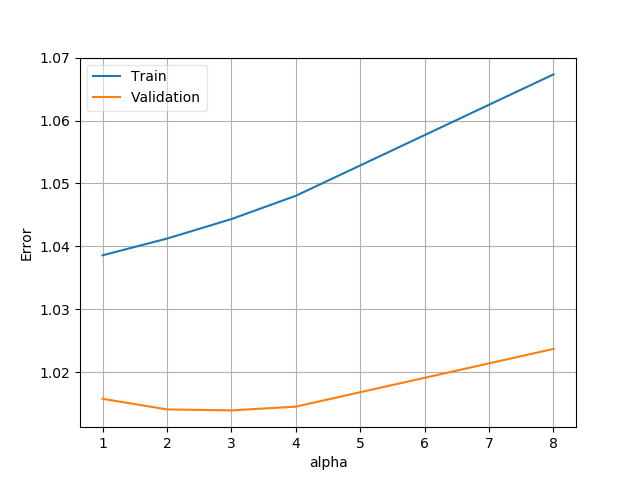

In [33]:
plot_train_val(hyper_df, model_base_name, 'alpha')

## 5.3 Ridge

In [34]:
from sklearn.linear_model import Ridge

We tune the strength of the `L2` regularizer through the `alpha` parameter

In [35]:
model_base_name = 'ridge_reg'
model_name_template = f'{model_base_name}_alpha_{{}}'

for alpha in [1, 2, 3, 4, 8]:
    print(f'Processing alpha={alpha}')
    model_name = model_name_template.format(alpha)
    if not model_name in hyper_df.loc[:, 'name'].values:
        ridge_reg = Ridge(alpha=alpha)
        # NOTE: We ravel in order to avoid warnings
        ridge_reg.fit(x_train_unscaled, y_train.values.ravel())
        ridge_reg_train_score = rmse_clip(y_train, ridge_reg.predict(x_train_unscaled))
        ridge_reg_val_score = rmse_clip(y_val, ridge_reg.predict(x_val_unscaled))
        if best_model(model_base_name, hyper_df, ridge_reg_val_score):
            pickle_object(model_dir, model_base_name, ridge_reg)
        hyper_df = add_to_hyper_df(hyper_df, hyper_df_path, model_name, ridge_reg_train_score, ridge_reg_val_score)
    else:
        ridge_reg_train_score = hyper_df.loc[hyper_df.loc[:, 'name'] == model_name, 'train_score'].values[0]
        ridge_reg_val_score = hyper_df.loc[hyper_df.loc[:, 'name'] == model_name, 'val_score'].values[0]
        ridge_reg = unpickle_object(model_dir, model_base_name)

Processing alpha=1
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/ridge_reg.pkl
Processing alpha=2
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/ridge_reg.pkl
Processing alpha=3
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/ridge_reg.pkl
Processing alpha=4
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/ridge_reg.pkl
Processing alpha=8
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/ridge_reg.pkl


<IPython.core.display.Javascript object>


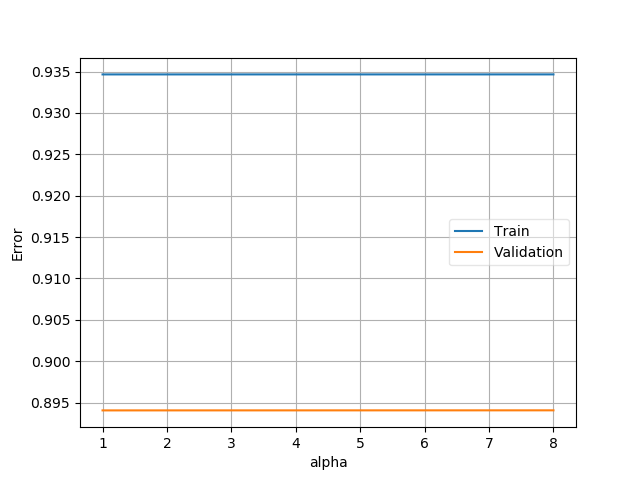

In [36]:
plot_train_val(hyper_df, model_base_name, 'alpha')

The ridge classifier appers to be in a bad health at the moment (given the ill-condition warnings). This is further discussed [here](https://github.com/scikit-learn/scikit-learn/issues/10517). Therefore, we will drop using the ridge classifier.

## 5.4 KNN

**NOTE**: The KNN uses forever to run, and it appears that it only uses one processor (even for `njobs=-1`). Note that KNN scales rather badly with number of points as seen [here](https://www.thekerneltrip.com/machine/learning/computational-complexity-learning-algorithms/) and [here](https://cs.stanford.edu/people/ang/papers/nips06-mapreducemulticore.pdf). To overcome the problem, we could use PCA analysis or t-SNE for dimensionality reduction. Similar arguments also holds for SVM as indicated [here](https://stackoverflow.com/questions/18165213/how-much-time-does-take-train-svm-classifier)

In [37]:
from sklearn.neighbors import KNeighborsRegressor

In [38]:
run_knn = False

In [39]:
model_name = 'knn_reg_n_neighbors_1'

if run_knn:
    if not model_name in hyper_df.loc[:, 'name'].values:
        knn_reg = KNeighborsRegressor(n_neighbors = 1)
        knn_reg.fit(x_train_scaled, y_train)
        knn_reg_train_score = rmse_clip(y_train, knn_reg.predict(x_train_scaled))
        knn_reg_val_score = rmse_clip(y_val, knn_reg.predict(x_val_scaled))
        pickle_object(model_dir, model_name, knn_reg)
        hyper_df = add_to_hyper_df(hyper_df, hyper_df_path, model_name, knn_reg_train_score, knn_reg_val_score)
    else:
        knn_reg_train_score = hyper_df.loc[hyper_df.loc[:, 'name'] == model_name, 'train_score'].values[0]
        knn_reg_val_score = hyper_df.loc[hyper_df.loc[:, 'name'] == model_name, 'val_score'].values[0]
        knn_reg = unpickle_object(model_dir, model_name)

## 5.5 Extremely Randomized Trees

In [40]:
from sklearn.ensemble import ExtraTreesRegressor

/home/michael/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


We would like to benchmark our results with [this notebook](https://www.kaggle.com/the1owl/playing-in-the-sandbox/notebook), which achieves a RMSE around $0.27$

In [41]:
model_base_name = 'et_reg'
model_name = f'{model_base_name}_n_estimators_25_max_depth_15'

if not model_name in hyper_df.loc[:, 'name'].values:
    et_reg = ExtraTreesRegressor(n_estimators=25,
                                 n_jobs=-1,
                                 max_depth=15,
                                 random_state=18)
    # NOTE: We ravel in order to avoid warnings
    et_reg.fit(x_train_unscaled, y_train.values.ravel())
    et_reg_train_score = rmse_clip(y_train, et_reg.predict(x_train_unscaled))
    et_reg_val_score = rmse_clip(y_val, et_reg.predict(x_val_unscaled))
    pickle_object(model_dir, model_base_name, et_reg)
    hyper_df = add_to_hyper_df(hyper_df, hyper_df_path, model_name, et_reg_train_score, et_reg_val_score)
else:
    et_reg_train_score = hyper_df.loc[hyper_df.loc[:, 'name'] == model_name, 'train_score'].values[0]
    et_reg_val_score = hyper_df.loc[hyper_df.loc[:, 'name'] == model_name, 'val_score'].values[0]
    et_reg = unpickle_object(model_dir, model_base_name)

Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/et_reg.pkl


In [42]:
print(f'Train score: {et_reg_train_score:.3f}')
print(f'Validation score: {et_reg_val_score:.3f}')

Train score: 0.669
Validation score: 0.828


Let's see if we can increase the score by first tuning the number of estimators

In [43]:
model_base_name = 'et_reg'
model_name_template = f'{model_base_name}_n_estimators_{{}}'

# Sklearn documentation:
# https://etboost.readthedocs.io/en/latest/python/python_api.html#module-etboost.sklearn
for n_estimators in [12, 25, 50, 75]:
    print(f'Processing n_estimators={n_estimators}')
    model_name = model_name_template.format(n_estimators)
    if not model_name in hyper_df.loc[:, 'name'].values:
        et_reg = ExtraTreesRegressor(n_estimators=n_estimators,
                                     n_jobs=-1,
                                     max_depth=15,
                                     random_state=18)
        # NOTE: We ravel in order to avoid warnings
        et_reg.fit(x_train_unscaled, y_train.values.ravel())
        et_reg_train_score = rmse_clip(y_train, et_reg.predict(x_train_unscaled))
        et_reg_val_score = rmse_clip(y_val, et_reg.predict(x_val_unscaled))
        if best_model(model_base_name, hyper_df, et_reg_val_score):
            pickle_object(model_dir, model_base_name, et_reg)
        hyper_df = add_to_hyper_df(hyper_df, hyper_df_path, model_name, et_reg_train_score, et_reg_val_score)
    else:
        et_reg_train_score = hyper_df.loc[hyper_df.loc[:, 'name'] == model_name, 'train_score'].values[0]
        et_reg_val_score = hyper_df.loc[hyper_df.loc[:, 'name'] == model_name, 'val_score'].values[0]
        et_reg = unpickle_object(model_dir, model_base_name)

Processing n_estimators=12
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/et_reg.pkl
Processing n_estimators=25
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/et_reg.pkl
Processing n_estimators=50
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/et_reg.pkl
Processing n_estimators=75
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/et_reg.pkl


<IPython.core.display.Javascript object>


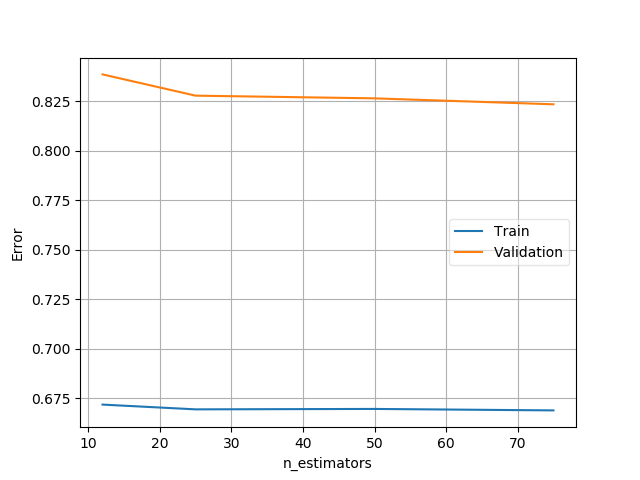

In [44]:
plot_train_val(hyper_df, model_base_name, 'n_estimators')

We gained a bit to have $75$ estimators, but it also costed time. Let's finally tune the `max_depth`

In [45]:
model_base_name = 'et_reg'
model_name_template = f'{model_base_name}_max_depth_{{}}'

# Sklearn documentation:
# https://etboost.readthedocs.io/en/latest/python/python_api.html#module-etboost.sklearn
for max_depth in [6, 8, 15, 20]:
    print(f'Processing max_depth={max_depth}')
    model_name = model_name_template.format(max_depth)
    if not model_name in hyper_df.loc[:, 'name'].values:
        et_reg = ExtraTreesRegressor(n_estimators=75,
                                     max_depth=max_depth,
                                     n_jobs=-1,
                                     random_state=18)
        # NOTE: We ravel in order to avoid warnings
        et_reg.fit(x_train_unscaled, y_train.values.ravel())
        et_reg_train_score = rmse_clip(y_train, et_reg.predict(x_train_unscaled))
        et_reg_val_score = rmse_clip(y_val, et_reg.predict(x_val_unscaled))
        if best_model(model_base_name, hyper_df, et_reg_val_score):
            pickle_object(model_dir, model_base_name, et_reg)
        hyper_df = add_to_hyper_df(hyper_df, hyper_df_path, model_name, et_reg_train_score, et_reg_val_score)
    else:
        et_reg_train_score = hyper_df.loc[hyper_df.loc[:, 'name'] == model_name, 'train_score'].values[0]
        et_reg_val_score = hyper_df.loc[hyper_df.loc[:, 'name'] == model_name, 'val_score'].values[0]
        et_reg = unpickle_object(model_dir, model_base_name)

Processing max_depth=6
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/et_reg.pkl
Processing max_depth=8
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/et_reg.pkl
Processing max_depth=15
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/et_reg.pkl
Processing max_depth=20
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/et_reg.pkl


<IPython.core.display.Javascript object>


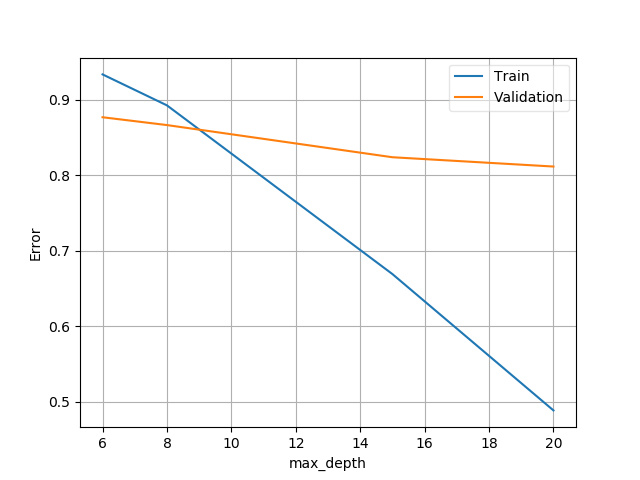

In [46]:
plot_train_val(hyper_df, model_base_name, 'max_depth', ['n_estimators'])

## 5.6 Gradient Boosting Decision Tree

In [47]:
from xgboost import XGBRegressor

As with the other estimators, the `xgboost` estimator has several knobs to turn which can be used to find the optimal estimator.

To start with, we have:

Better fitting (increase for reducing underfit)
* max_depth
* subsample
* colsample_bytree
* colsample_bylevel
* eta 
* num_round

Impeeds fitting (increase for reducing overfitting)
* min_child_weight
* lambda
* alpha

We will start with the `max_depth` parameter to investigate the performance

In [48]:
model_base_name = 'xg_reg'
model_name_template = f'{model_base_name}_max_depth_{{}}'

# Sklearn documentation:
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn
for max_depth in [0, 1, 2, 3, 4, 5, 6, 8, 10, 14]:
    print(f'Processing max_depth={max_depth}')
    model_name = model_name_template.format(max_depth)
    if not model_name in hyper_df.loc[:, 'name'].values:
        xg_reg = XGBRegressor(max_depth=max_depth,
                              n_jobs=-1,
                              seed=seed)
        # NOTE: We ravel in order to avoid warnings
        xg_reg.fit(x_train_unscaled, y_train.values.ravel())
        xg_reg_train_score = rmse_clip(y_train, xg_reg.predict(x_train_unscaled))
        xg_reg_val_score = rmse_clip(y_val, xg_reg.predict(x_val_unscaled))
        if best_model(model_base_name, hyper_df, xg_reg_val_score):
            pickle_object(model_dir, model_base_name, xg_reg)
        hyper_df = add_to_hyper_df(hyper_df, hyper_df_path, model_name, xg_reg_train_score, xg_reg_val_score)
    else:
        xg_reg_train_score = hyper_df.loc[hyper_df.loc[:, 'name'] == model_name, 'train_score'].values[0]
        xg_reg_val_score = hyper_df.loc[hyper_df.loc[:, 'name'] == model_name, 'val_score'].values[0]
        xg_reg = unpickle_object(model_dir, model_base_name)

Processing max_depth=0
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/xg_reg.pkl
Processing max_depth=1
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/xg_reg.pkl
Processing max_depth=2
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/xg_reg.pkl
Processing max_depth=3
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/xg_reg.pkl
Processing max_depth=4
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/xg_reg.pkl
Processing max_depth=5
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/xg_reg.pkl
Processing

<IPython.core.display.Javascript object>


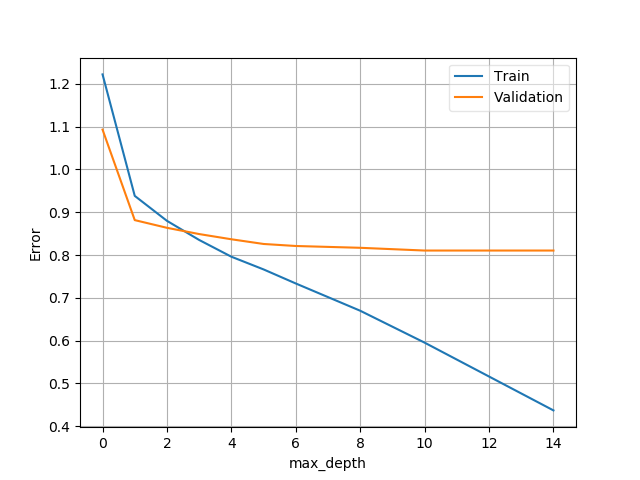

In [49]:
plot_train_val(hyper_df, model_base_name, 'max_depth', ['min_child_weigh'])

Let's try to make a submission with this, to see if we are doing any better than our mean prediction

In [50]:
xg_prediction = test_dt.loc[:, ['ID']]
xg_prediction.loc[:, 'item_cnt_month'] = xg_reg.predict(test_dt).clip(0, 20)

# Set ID as index
xg_prediction.set_index('ID', inplace=True)

xg_prediction.to_csv(generated_data.joinpath('xg_prediction.csv'))
xg_prediction.loc[:, 'item_cnt_month'].describe()

count    214200.000000
mean          0.204178
std           0.621583
min           0.000000
25%           0.016349
50%           0.059120
75%           0.179073
max          20.000000
Name: item_cnt_month, dtype: float64

In [51]:
test_dt.columns

Index(['date_block_num', 'shop_revenue_avg', 'shop_unique_items_len',
       'shop_id_mean_mean_enc', 'item_id_mean_mean_enc',
       'item_category_id_mean_mean_enc',
       'month_shop_item_id_item_cnt_sum_lag_1',
       'month_shop_item_id_item_cnt_sum_lag_2',
       'month_shop_item_id_item_cnt_sum_lag_3',
       'month_shop_item_id_item_cnt_sum_lag_6',
       'month_shop_item_id_item_cnt_sum_lag_9',
       'month_shop_item_id_item_cnt_sum_lag_12',
       'month_shop_item_cnt_sum_lag_1', 'month_shop_item_cnt_sum_lag_2',
       'month_shop_item_cnt_sum_lag_3', 'month_shop_item_cnt_sum_lag_6',
       'month_shop_item_cnt_sum_lag_9', 'month_shop_item_cnt_sum_lag_12',
       'month_item_id_item_cnt_sum_lag_1', 'month_item_id_item_cnt_sum_lag_2',
       'month_item_id_item_cnt_sum_lag_3', 'month_item_id_item_cnt_sum_lag_6',
       'month_item_id_item_cnt_sum_lag_9', 'month_item_id_item_cnt_sum_lag_12',
       'month_shop_item_id_item_cnt_max_lag_1',
       'month_shop_item_id_item_cnt_m

This gave a leader board score of $1.07932$, which is better than the mean predictions. Let us improve the validation score even further. From the graph above, it appears that we are [overfitting](http://scikit-learn.org/stable/modules/learning_curve.html#validation-curve) as the training error improves, whereas the validation error is flatting out. Let's increase `min_child_weight`

In [52]:
model_base_name = 'xg_reg'
model_name_template = f'{model_base_name}_max_depth_14_min_child_weight_{{}}'

# Sklearn documentation:
# https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn
for min_child_weight in [1, 2, 4, 8, 16, 32, 64, 128, 256]:
    print(f'Processing min_child_weight={min_child_weight}')
    model_name = model_name_template.format(min_child_weight)
    if not model_name in hyper_df.loc[:, 'name'].values:
        xg_reg = XGBRegressor(max_depth=14,
                              min_child_weight=min_child_weight,
                              n_jobs=-1,
                              seed=seed)
        # NOTE: We ravel in order to avoid warnings
        xg_reg.fit(x_train_unscaled, y_train.values.ravel())
        xg_reg_train_score = rmse_clip(y_train, xg_reg.predict(x_train_unscaled))
        xg_reg_val_score = rmse_clip(y_val, xg_reg.predict(x_val_unscaled))
        if best_model(model_base_name, hyper_df, xg_reg_val_score):
            pickle_object(model_dir, model_base_name, xg_reg)
        hyper_df = add_to_hyper_df(hyper_df, hyper_df_path, model_name, xg_reg_train_score, xg_reg_val_score)
    else:
        xg_reg_train_score = hyper_df.loc[hyper_df.loc[:, 'name'] == model_name, 'train_score'].values[0]
        xg_reg_val_score = hyper_df.loc[hyper_df.loc[:, 'name'] == model_name, 'val_score'].values[0]
        xg_reg = unpickle_object(model_dir, model_base_name)

Processing min_child_weight=1
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/xg_reg.pkl
Processing min_child_weight=2
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/xg_reg.pkl
Processing min_child_weight=4
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/xg_reg.pkl
Processing min_child_weight=8
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/xg_reg.pkl
Processing min_child_weight=16
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/xg_reg.pkl
Processing min_child_weight=32
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project

<IPython.core.display.Javascript object>


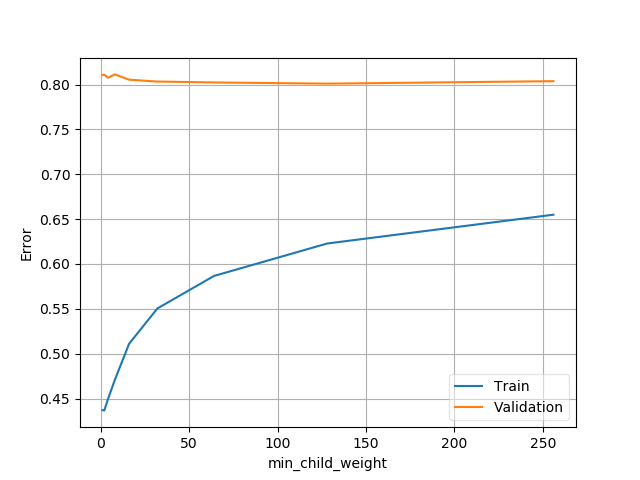

In [53]:
plot_train_val(hyper_df, model_base_name, 'min_child_weight')

We observe a minimum around $128$. We could continue to tune the hyperparameters, but we stop here due to time constraints.

## 5.7 Neural network

In [54]:
from keras import backend as K
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

**NOTE**: We also make a costum RMSE for keras

In [55]:
def rmse_keras_clip(y_true, y_pred):
    """
    Returns the root mean squared error of the predictions
    
    The root mean squared error is defined by:
    $\sqrt {\frac {\sum _{t=1}^{T}({\hat {y}}_{t}-y_{t})^{2}}{T}}$
    
    Note
    ----
    This version clips the predictions to [0, 20]
    
    Parameters
    ----------
    y_true : array, shape (n_samples,)
        The correct prediction (the ground truth)
    y_pred : array, shape (n_samples,)
        The predictions
        
    Returns
    -------
    rmse : float
        The root mean squared error
    """
    return K.sqrt(K.mean(K.square(tf.clip_by_value(y_pred, 0, 20) - y_true), axis=-1))

**NOTE**: RNNs would probably be the best fit for this task, we will for simplicity use plain old multilayer perceptrons

In [56]:
def build_mlp(input_dim, optimizer, rmse_keras_clip, hidden_layers=1, nodes=32, dropout=0, silent=False):
    """
    Returns a keras model
    
    Parameters
    ----------
    input_dim : int
        The input dimension
    hidden_layers : int
        The number of hidden layers
    optimizer : str
        The optimizer to use
    rmse_keras_clip : function
        Function which gives the rmse loss function
    nodes : int or array-like, shape (hidden_layers)
        Nodes for all the layers.
        If array-like, each element corresponds to the nodes in the hidden layer
        If int, all hidden layers will have the same number of nodes
    dropout : float or array-like, shape (hidden_layers)
        Dropout for all the layers.
        If array-like, each element corresponds to the dropout values after each hidden layer
        If int, all hidden layers will have the same dropout value
    silent : bool
        If False the summary will be printed
    """
    
    if type(nodes) == int:
        nodes = [nodes] * hidden_layers
    if type(dropout) == float or type(dropout) == int:
        dropout = [dropout] * hidden_layers
    
    model = Sequential()

    model.add(Dense(nodes[0], input_dim=input_dim))
    
    if len(nodes) > 1:
        model.add(Activation('relu'))
    
    for node, drop in zip(nodes[1:], dropout[:-1]):
        model.add(Dropout(drop))
        model.add(Dense(node))
        
        if node != nodes[-1]:
            model.add(Activation('relu'))

    # Add the final layer
    model.add(Dropout(dropout[-1]))
    model.add(Dense(1))
    # NOTE: We use identity as we are dealing with a regression problem
    model.add(Activation('linear'))

    model.compile(loss=rmse_keras_clip,
                  optimizer=optimizer,
                  metrics=[rmse_keras_clip])
    
    if not silent:
        model.summary()

    return model

For the neural networks, it makes sense to investigate

Better fitting (increase for reducing underfit)
* Number of neurons per layer
* Number of layers
* Adam/Adadelta/Adagrad/... (observed to lead to more overfitting)
* Batch size

Impeeds fitting (increase for reducing overfitting)
* L2/L1 for weights
* Dropout/Dropconnect
* Static dropconnect

We start by optimizing one layer

In [57]:
stopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto', baseline=None)

In [58]:
model_base_name = 'nn_reg'
model_name_template = f'{model_base_name}_nodes_{{}}'

for node in (8, 16, 32, 64, 128, 256):
    print(f'Processing nodes={node}')
    model_name = model_name_template.format(node)
    model_path = model_dir.joinpath(f'{model_name}.hdf')
    checkpointer = ModelCheckpoint(filepath=str(model_path),
                                   verbose=1, 
                                   save_best_only=True)
    
    if not model_name in hyper_df.loc[:, 'name'].values:
        nn_reg = build_mlp(train_non_dt.shape[1], 
                           'adadelta',
                           rmse_keras_clip,
                           hidden_layers=1,
                           nodes=node,
                           dropout=0.32)
        
        nn_reg.fit(x_train_scaled, 
                   y_train, 
                   validation_data=(x_val_scaled, y_val),
                   batch_size=4096,
                   epochs=10,
                   callbacks=[checkpointer, stopper])
        history = nn_reg.history.history
        pickle_object(model_dir, f'{model_name}', history)
        
        # NOTE: Find the best scores
        nn_reg_val_score = min(nn_reg.history.history['val_loss'])
        index = np.where(np.isclose(history['val_loss'], nn_reg_val_score))[0][0]
        nn_reg_train_score = history['loss'][index]
        hyper_df = add_to_hyper_df(hyper_df, hyper_df_path, model_name, nn_reg_train_score, nn_reg_val_score)
    else:
        nn_reg = load_model(model_path, custom_objects={'rmse_keras_clip': rmse_keras_clip})
        history = unpickle_object(model_dir, f'{model_name}')
        nn_reg_train_score = hyper_df.loc[hyper_df.loc[:, 'name'] == model_name, 'train_score'].values[0]
        nn_reg_val_score = hyper_df.loc[hyper_df.loc[:, 'name'] == model_name, 'val_score'].values[0]

Processing nodes=8
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/nn_reg_nodes_8.pkl
Processing nodes=16
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/nn_reg_nodes_16.pkl
Processing nodes=32
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/nn_reg_nodes_32.pkl
Processing nodes=64
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/nn_reg_nodes_64.pkl
Processing nodes=128
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/nn_reg_nodes_128.pkl
Processing nodes=256
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/

<IPython.core.display.Javascript object>


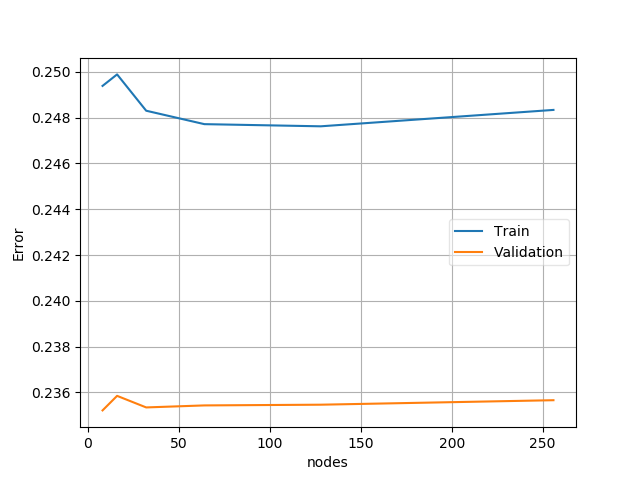

In [59]:
plot_train_val(hyper_df, model_base_name, 'nodes')

The plot is somewhat surprising as the validation error is lower than the training error.
One hypothesis could be that we should have trained for more epochs. However, the model with $256$ nodes ended with early stopping. 

As the score is quite low as compared to the other models we have fitted, we can probe the submit with the last fitted network

In [60]:
nn_prediction = test_dt.loc[:, ['ID']]
nn_prediction.loc[:, 'item_cnt_month'] = nn_reg.predict(test_non_dt).clip(0, 20)

# Set ID as index
nn_prediction.set_index('ID', inplace=True)

nn_prediction.to_csv(generated_data.joinpath('nn_prediction.csv'))
nn_prediction.loc[:, 'item_cnt_month'].describe()

count    214200.000000
mean          0.078043
std           0.593744
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          20.000000
Name: item_cnt_month, dtype: float64

This gave a submission score of $1.05710$, which is actually not that bad. Although $256$ did not had the lowest score, lets add more layers with $128$ nodes to see if we can improve things a bit. Notice that we increase the number of epochs as more complex networks usually needs more epochs

In [61]:
model_base_name = 'nn_reg'
model_name_template = f'{model_base_name}_layer_{{}}'

for layer in (2, 3, 4):
    nodes = [256] + [128] * (layer - 1)
    print(f'Processing layers={layer}')
    model_name = model_name_template.format(layer)
    model_path = model_dir.joinpath(f'{model_name}.hdf')
    checkpointer = ModelCheckpoint(filepath=str(model_path),
                                   verbose=1, 
                                   save_best_only=True)
    
    if not model_name in hyper_df.loc[:, 'name'].values:
        nn_reg = build_mlp(train_non_dt.shape[1], 
                           'adadelta',
                           rmse_keras_clip,
                           hidden_layers=1,
                           nodes=nodes,
                           dropout=0.32)
        
        nn_reg.fit(x_train_scaled, 
                   y_train, 
                   validation_data=(x_val_scaled, y_val),
                   batch_size=4096,
                   epochs=100,
                   callbacks=[checkpointer, stopper])
        history = nn_reg.history.history
        pickle_object(model_dir, f'{model_name}', history)
        
        # NOTE: Find the best scores
        nn_reg_val_score = min(nn_reg.history.history['val_loss'])
        index = np.where(np.isclose(history['val_loss'], nn_reg_val_score))[0][0]
        nn_reg_train_score = history['loss'][index]
        hyper_df = add_to_hyper_df(hyper_df, hyper_df_path, model_name, nn_reg_train_score, nn_reg_val_score)
    else:
        nn_reg = load_model(model_path, custom_objects={'rmse_keras_clip': rmse_keras_clip})
        history = unpickle_object(model_dir, f'{model_name}')
        nn_reg_train_score = hyper_df.loc[hyper_df.loc[:, 'name'] == model_name, 'train_score'].values[0]
        nn_reg_val_score = hyper_df.loc[hyper_df.loc[:, 'name'] == model_name, 'val_score'].values[0]

Processing layers=2
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/nn_reg_layer_2.pkl
Processing layers=3
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/nn_reg_layer_3.pkl
Processing layers=4
Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/nn_reg_layer_4.pkl


<IPython.core.display.Javascript object>


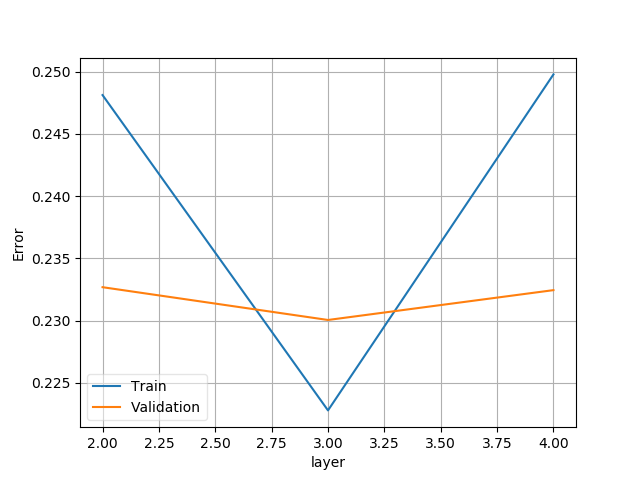

In [62]:
plot_train_val(hyper_df, model_base_name, 'layer')

# 6 Ensembling

Let us now investigate the performances of all models

In [63]:
hyper_df.sort_values('name', axis=0, inplace=True)
hyper_df.reset_index(drop=True, inplace=True)
hyper_df.to_hdf(hyper_df_path, key='hyper_df')
hyper_df

,name,train_score,val_score
0,et_reg_max_depth_15,0.668920,0.823585
1,et_reg_max_depth_20,0.488460,0.811277
2,et_reg_max_depth_6,0.933245,0.876535
3,et_reg_max_depth_8,0.892242,0.866167
4,et_reg_n_estimators_12,0.671854,0.838693
5,et_reg_n_estimators_25,0.669444,0.827953
6,et_reg_n_estimators_25_max_depth_15,0.669444,0.827953
7,et_reg_n_estimators_50,0.669660,0.826594
8,et_reg_n_estimators_75,0.668920,0.823585
9,lasso_reg_alpha_1,1.038569,1.015744


## Best regressors

From this we create the best regressors

### Best linear regressor

In [64]:
best_lin_reg = LinearRegression()

### Best lasso regressor

In [65]:
lasso_df = hyper_df.loc[hyper_df.loc[:, 'name'].str.contains('lasso')]
lasso_df.loc[np.isclose(lasso_df.loc[:, 'val_score'], lasso_df.loc[:, 'val_score'].min())]

,name,train_score,val_score
11,lasso_reg_alpha_3,1.044328,1.013899


In [66]:
best_lasso_reg = Lasso(alpha=3)

### Best extra tree regressor

In [67]:
et_df = hyper_df.loc[hyper_df.loc[:, 'name'].str.contains('et')]
et_df.loc[np.isclose(et_df.loc[:, 'val_score'], et_df.loc[:, 'val_score'].min())]

,name,train_score,val_score
1,et_reg_max_depth_20,0.48846,0.811277


We recall that we did this tuning with `n_estimators=75`.

In [68]:
best_et_reg = ExtraTreesRegressor(n_estimators=75,
                                  max_depth=max_depth,
                                  n_jobs=-1,
                                  random_state=18)

### Best extreme gradient regressor

In [69]:
xg_df = hyper_df.loc[hyper_df.loc[:, 'name'].str.contains('xg')]
xg_df.loc[np.isclose(xg_df.loc[:, 'val_score'], xg_df.loc[:, 'val_score'].min())]

,name,train_score,val_score
34,xg_reg_max_depth_14_min_child_weight_128,0.622761,0.800968


In [70]:
best_xg_reg = XGBRegressor(max_depth=14,
                           min_child_weight=128,
                           n_jobs=-1,
                           seed=seed)

### Best neural net regressor

In [71]:
nn_df = hyper_df.loc[hyper_df.loc[:, 'name'].str.contains('nn')]
nn_df.loc[np.isclose(nn_df.loc[:, 'val_score'], nn_df.loc[:, 'val_score'].min())]

,name,train_score,val_score
16,nn_reg_layer_3,0.222782,0.230049


We recall that this network was built with $256$ initial nodes, then subsequent $128$ nodes

In [72]:
best_nn_reg = build_mlp(train_non_dt.shape[1], 
                        'adadelta',
                        rmse_keras_clip,
                        hidden_layers=3,
                        nodes=[256, 128, 128],
                        dropout=0.32)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               17664     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

## First level

In the first level we predict with our optimized classifiers, just as we would've done if we were to use only one of the models for the final prediction.

In [73]:
best_name = 'best_lin_reg'
if not model_dir.joinpath(best_name + '.pkl').is_file():
    best_lin_reg.fit(train_non_dt, target)
    pickle_object(model_dir, best_name, best_lin_reg)
else:
    best_lin_reg = unpickle_object(model_dir, best_name)
    
lin_lvl_1_pred = best_lin_reg.predict(test_non_dt)

Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/best_lin_reg.pkl


In [74]:
best_name = 'best_lasso_reg'
if not model_dir.joinpath(best_name + '.pkl').is_file():
    best_lasso_reg.fit(train_non_dt, target)
    pickle_object(model_dir, best_name, best_lasso_reg)
else:
    best_lasso_reg = unpickle_object(model_dir, best_name)
    
lasso_lvl_1_pred = best_lasso_reg.predict(test_non_dt)

Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/best_lasso_reg.pkl


In [75]:
best_name = 'best_et_reg'
if not model_dir.joinpath(best_name + '.pkl').is_file():
    best_et_reg.fit(train_dt, target.values.ravel())
    pickle_object(model_dir, best_name, best_et_reg)
else:
    best_et_reg = unpickle_object(model_dir, best_name)
    
et_lvl_1_pred = best_et_reg.predict(test_dt)

Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/best_et_reg.pkl


In [76]:
best_name = 'best_xg_reg'
if not model_dir.joinpath(best_name + '.pkl').is_file():
    best_xg_reg.fit(train_dt, target.values.ravel())
    pickle_object(model_dir, best_name, best_xg_reg)
else:
    best_xg_reg = unpickle_object(model_dir, best_name)
    
xg_lvl_1_pred = best_xg_reg.predict(test_dt)

Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/best_xg_reg.pkl


In [77]:
best_name = 'best_nn_reg'
model_path = model_dir.joinpath(f'{best_name}.hdf')
stopper = EarlyStopping(monitor='loss', patience=2, verbose=1, mode='auto', baseline=None)

if not model_path.is_file():
    # NOTE: We use a lower patience as we would not like to overfit the network
    checkpointer = ModelCheckpoint(filepath=str(model_path),
                                   monitor='loss',
                                   verbose=1, 
                                   save_best_only=True)
    best_nn_reg.fit(train_non_dt, target, batch_size=4096, epochs=100, callbacks=[checkpointer, stopper])
else:
    best_nn_reg = load_model(model_path, custom_objects={'rmse_keras_clip': rmse_keras_clip})
    print(f'Loaded from {model_path}')
    
nn_lvl_1_pred = best_nn_reg.predict(test_non_dt)

Loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/models/best_nn_reg.hdf


Let's see how well we can do with the prediction of the model with the best loss. As there are some discrepancies between the neural net values and the other, we submit both the best neural network, and the best extreme gradient regressor

In [78]:
best_nn_prediction = test_dt.loc[:, ['ID']]
best_nn_prediction.loc[:, 'item_cnt_month'] = nn_lvl_1_pred.clip(0, 20)

# Set ID as index
best_nn_prediction.set_index('ID', inplace=True)

best_nn_prediction.to_csv(generated_data.joinpath('best_nn_prediction.csv'))
best_nn_prediction.loc[:, 'item_cnt_month'].describe()

count    214200.000000
mean          0.102218
std           0.663131
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          20.000000
Name: item_cnt_month, dtype: float64

This gives a score of $1.06557$, which is sligthly worse then the previous neural network submission. It is likely that overfitting is the reason.

In [79]:
best_xg_prediction = test_dt.loc[:, ['ID']]
best_xg_prediction.loc[:, 'item_cnt_month'] = xg_lvl_1_pred.clip(0, 20)

# Set ID as index
best_xg_prediction.set_index('ID', inplace=True)

best_xg_prediction.to_csv(generated_data.joinpath('best_xg_prediction.csv'))
best_xg_prediction.loc[:, 'item_cnt_month'].describe()

count    214200.000000
mean          0.239251
std           0.676189
min           0.000000
25%           0.025818
50%           0.079885
75%           0.208633
max          20.000000
Name: item_cnt_month, dtype: float64

This gave the score of $1.00418$, which is so far the best.

## Second level

Combine the prediction to the new "unseen" level $2$ test set.

First, we will make a test set we can predict the meta model(s) on level $2$ on.

**NOTE**: We will stop after level $2$, so we will only have one meta model on level $2$, but in principle we could have several models on level $2$ to make up the test set of level $3$

In [80]:
x_test_lvl_2 = np.c_[lin_lvl_1_pred.clip(0, 20), 
                     lasso_lvl_1_pred.clip(0, 20),
                     et_lvl_1_pred.clip(0, 20),
                     xg_lvl_1_pred.clip(0, 20),
                     nn_lvl_1_pred.clip(0, 20)] 

Next, we declare the target for the meta model on level $2$.

As we only have one meta model on level $2$, we will use the $5$ last months to create for the k-fold validation on level $2$. We start by getting the first index of the target

In [81]:
n_last_month = 6
max_month = train_dt.loc[:, 'date_block_num'].max()
# NOTE: Add one as range has non-inclusive endpoint
month_range = np.array(range(max_month - n_last_month, max_month + 1))
first_index = train_dt.shape[0] - train_dt.loc[train_dt.loc[:, 'date_block_num'].isin(month_range)].shape[0]

In [82]:
y_train_lvl_2 = target.iloc[first_index:]

Declare the training set, which we will fill with the k-fold procedure

In [83]:
x_train_lvl_2 = np.zeros([y_train_lvl_2.shape[0], x_test_lvl_2.shape[1]])

In [84]:
x_train_lvl_2_path = generated_data.joinpath('x_train_lvl_2.hdf')

In [85]:
index_offset = 0
if not x_train_lvl_2_path.is_file():
    for month in month_range:
        print(f'Processing month: {month}')
        # Find indices
        first_index = train_dt.shape[0] - train_dt.loc[train_dt.loc[:, 'date_block_num'] < month].shape[0]
        last_index = first_index + train_dt.loc[train_dt.loc[:, 'date_block_num'] == month].shape[0]
        
        # Split to train and validate
        x_train_scaled = train_non_dt.iloc[:first_index]
        x_train_unscaled = train_dt.iloc[:first_index]
        y_train = target.iloc[:first_index]
        x_val_scaled = train_non_dt.iloc[first_index:last_index]
        x_val_unscaled = train_dt.iloc[first_index:last_index]    

        # Make new models (where necessary)
        nn_reg_lvl_2 = build_mlp(x_train_unscaled.shape[1], 
                                 'adadelta',
                                 rmse_keras_clip,
                                 hidden_layers=3,
                                 nodes=[256, 128, 128],
                                 dropout=0.32,
                                 silent=True)          
        
        # Fit
        print(f'    - fitting linear model')
        best_lin_reg.fit(x_train_scaled, y_train)
        print(f'    - fitting lasso model')
        best_lasso_reg.fit(x_train_scaled, y_train)
        print(f'    - fitting extra tree model')
        best_et_reg.fit(x_train_unscaled, y_train.values.ravel())
        print(f'    - fitting extra gradient dt model')
        best_xg_reg.fit(x_train_unscaled, y_train.values.ravel())
        print(f'    - fitting nn model')
        nn_reg_lvl_2.fit(x_train_scaled, y_train, batch_size=4096, epochs=100, callbacks=[stopper])
        
        # Predict
        lin_lvl_2_pred = best_lin_reg.predict(x_val_scaled)
        lasso_lvl_2_pred = best_lasso_reg.predict(x_val_scaled)
        et_lvl_2_pred = best_et_reg.predict(x_val_unscaled)
        xg_lvl_2_pred = best_xg_reg.predict(x_val_unscaled)
        nn_lvl_2_pred = nn_reg_lvl_2.predict(x_val_scaled)
        
        # Store the predictions in the training set
        row_inds = np.array(range(index_offset, last_index - first_index + index_offset))
        x_train_lvl_2[row_inds, 0] = lin_lvl_2_pred.clip(0, 20).ravel()
        x_train_lvl_2[row_inds, 1] = lasso_lvl_2_pred.clip(0, 20).ravel()
        x_train_lvl_2[row_inds, 2] = et_lvl_2_pred.clip(0, 20).ravel()
        x_train_lvl_2[row_inds, 3] = xg_lvl_2_pred.clip(0, 20).ravel()
        x_train_lvl_2[row_inds, 4] = nn_lvl_2_pred.clip(0, 20).ravel()
        
        # Update index_offset
        index_offset = last_index - first_index
    x_train_lvl_2_df = pd.DataFrame(x_train_lvl_2, 
                                    columns=['lin_pred', 'lasso_pred', 'et_pred', 'xg_pred', 'nn_pred'])
    x_train_lvl_2_df.to_hdf(generated_data.joinpath('x_train_lvl_2.hdf'), key='x_train_lvl_2')
else:
    x_train_lvl_2_df = pd.read_hdf(x_train_lvl_2_path, key='x_train_lvl_2')
    print(f'x_train_lvl_2_df loaded from {x_train_lvl_2_path}')

x_train_lvl_2_df loaded from /home/michael/coursera_advanced_machine_learning/course_2_competitive_data_science/final_project/generated_data/x_train_lvl_2.hdf


In [86]:
x_train_lvl_2_df.describe()

,lin_pred,lasso_pred,et_pred,xg_pred,nn_pred
count,1.614364e+06,1.614364e+06,1.614364e+06,1.614364e+06,1.614364e+06
mean,2.148994e+00,8.851118e-02,8.991126e-02,8.799581e-02,6.022153e-02
std,6.151237e+00,1.343074e-01,5.101440e-01,5.399148e-01,5.669296e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,2.786119e-01,3.276341e-02,1.087818e-02,0.000000e+00
max,2.000000e+01,3.052416e-01,2.000000e+01,2.000000e+01,2.000000e+01


The big question is now what model to use as the final model.

The rule of thumb is to have "simpler" models. Let's try with a linear model 

We now train on the validation months, and predict using the test set for level $2$. 

**NOTE**: We are fitting on only the last months, and predicting for the prediction month

In [87]:
final_lin = LinearRegression()
final_lin.fit(x_train_lvl_2_df, y_train_lvl_2)
final_lin_prediction = final_lin.predict(x_test_lvl_2)

In [88]:
lin_stack_prediction = test_dt.loc[:, ['ID']]
lin_stack_prediction.loc[:, 'item_cnt_month'] = final_lin_prediction.clip(0, 20)

# Set ID as index
lin_stack_prediction.set_index('ID', inplace=True)

lin_stack_prediction.to_csv(generated_data.joinpath('lin_stack_prediction.csv'))
lin_stack_prediction.loc[:, 'item_cnt_month'].describe()

count    214200.000000
mean          0.244657
std           0.001612
min           0.196671
25%           0.244687
50%           0.244898
75%           0.245021
max           0.260311
Name: item_cnt_month, dtype: float64

It appears this is close to a mean submission as numbers cluster around $0.244$ items, however, if we look at the distributions for the best predictors, the $75$-percentile is still around $0.0$. Let's see if we can get more diversity from a shallow xgb model

In [89]:
final_xg = XGBRegressor(max_depth=10,
                        min_child_weight=10,
                        n_jobs=-1,
                        seed=seed)
final_xg.fit(x_train_lvl_2_df.values, y_train_lvl_2.values.ravel())
final_xg_prediction = final_xg.predict(x_test_lvl_2)

In [90]:
xg_stack_prediction = test_dt.loc[:, ['ID']]
xg_stack_prediction.loc[:, 'item_cnt_month'] = final_xg_prediction.clip(0, 20)

# Set ID as index
xg_stack_prediction.set_index('ID', inplace=True)

xg_stack_prediction.to_csv(generated_data.joinpath('xg_stack_prediction.csv'))
xg_stack_prediction.loc[:, 'item_cnt_month'].describe()

count    214200.000000
mean          0.186897
std           0.067300
min           0.000000
25%           0.159708
50%           0.184231
75%           0.201676
max           2.691110
Name: item_cnt_month, dtype: float64

As the max only reaches $2.74$, we can expect high penalties from large numbers. In fact, this prediction gives a loss of $1.22040$ on the leaderboard, which is rather bad. Probably we've been too harsh on the `min_child_weight`. Let's relax it

In [91]:
final_xg_min_child_1 = XGBRegressor(max_depth=10,
                                    min_child_weight=1,
                                    n_jobs=-1,
                                    seed=seed)
final_xg_min_child_1.fit(x_train_lvl_2_df.values, y_train_lvl_2.values.ravel())
final_xg_min_child_1_prediction = final_xg_min_child_1.predict(x_test_lvl_2)

In [92]:
xg_min_child_1_stack_prediction = test_dt.loc[:, ['ID']]
xg_min_child_1_stack_prediction.loc[:, 'item_cnt_month'] = final_xg_min_child_1_prediction.clip(0, 20)

# Set ID as index
xg_min_child_1_stack_prediction.set_index('ID', inplace=True)

xg_min_child_1_stack_prediction.to_csv(generated_data.joinpath('xg_min_child_1_stack_prediction.csv'))
xg_min_child_1_stack_prediction.loc[:, 'item_cnt_month'].describe()

count    214200.000000
mean          0.184948
std           0.161007
min           0.000000
25%           0.155779
50%           0.170136
75%           0.192091
max          13.318018
Name: item_cnt_month, dtype: float64

We see that the distribution improves a bit. The prediction gives a loss of $1.22864$ on the leaderboard, which is even worse.
Therefore, our official submission will our best gradient boost model with a score of $1.00418$.